In [4]:
from matplotlib import pyplot as plt
import tensorflow as tf
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms as T
from torchvision import transforms
import torch
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import pytorch_msssim
import torchvision.models as models
import torchvision.transforms as transforms
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Mon Aug 12 14:04:40 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        Off |   00000000:01:00.0  On |                  N/A |
| 38%   52C    P0             N/A /  115W |    1780MiB /   8188MiB |      8%      Default |
|                                         |                        |                  N/A |
+--

In [5]:
from matplotlib import pyplot as plt
import tensorflow as tf
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms as T
from torchvision import transforms
import torch
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import pytorch_msssim
import torchvision.models as models
import torchvision.transforms as transforms
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Mon Aug 12 14:04:44 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.67                 Driver Version: 550.67         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        Off |   00000000:01:00.0  On |                  N/A |
| 38%   50C    P3             N/A /  115W |    1804MiB /   8188MiB |     13%      Default |
|                                         |                        |                  N/A |
+--

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

HIDDEN_SIZE = 256
xx = HIDDEN_SIZE//8
embedding = 128


# Определение модели энкодера
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, HIDDEN_SIZE, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(HIDDEN_SIZE//2 * xx * xx, embedding*4)
        self.fc2 = nn.Linear(embedding*4, embedding*2)
        self.fc3 = nn.Linear(embedding*2, embedding)
        self.drop = nn.Dropout(0.25)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        x = torch.tanh(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        coords = self.fc3(x)
        return coords

# Определение модели декодера
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(embedding, embedding*2)
        self.fc2 = nn.Linear(embedding*2, embedding*4)
        self.fc3 = nn.Linear(embedding*4, HIDDEN_SIZE//2 * xx * xx)
        self.deconv1 = nn.ConvTranspose2d(HIDDEN_SIZE//2, HIDDEN_SIZE, kernel_size=3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(HIDDEN_SIZE, HIDDEN_SIZE, kernel_size=3, padding=1)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv3 = nn.ConvTranspose2d(HIDDEN_SIZE, 3, kernel_size=3, padding=1)
        self.drop = nn.Dropout(0.25)

    def forward(self, coords):
        x = self.fc1(coords)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.fc3(x)
        x = x.view(x.size(0), HIDDEN_SIZE//2, xx, xx)  # Reshape to match deconv1's input
        x = self.up(x)
        x = torch.tanh(self.deconv1(x))
        x = self.drop(x)
        x = self.up(x)
        x = torch.tanh(self.deconv2(x))
        x = self.up(x)
        decoded = torch.tanh(self.deconv3(x))
        return decoded

# Полный автоэнкодер
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        coords = self.encoder(x)
        decoded = self.decoder(coords)
        return decoded, coords

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)

/tmp/ipykernel_7814/1157294653.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


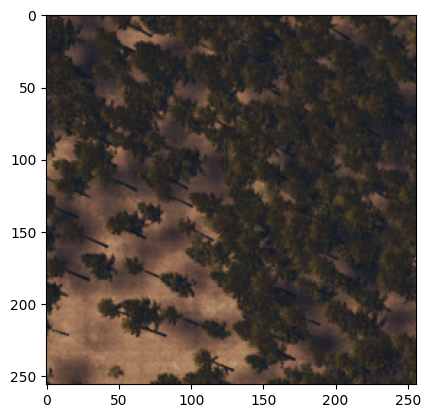

0


In [3]:
dataset_path = 'coordinates_dataset.csv'
# Гиперпараметры
batch_size = 8
learning_rate = 1e-4
num_epochs = 25



resize_to = HIDDEN_SIZE



# Датасет для загрузки изображений и координат
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['cell_path']
        center_x = self.data.iloc[idx]['center_x']
        center_y = self.data.iloc[idx]['center_y']

        image = Image.open(image_path).convert("RGB")
        image = image.resize((resize_to, resize_to))
        if self.transform:
            image = self.transform(image)

        # print(image_path[6:], [center_x, center_y])
        return torch.tensor(image)

    


# Параметры генератора данных
csv_file = 'coordinates_dataset.csv'
    

    
dataloader = CustomDataset(csv_file=csv_file, transform=transforms.ToTensor())
dataloader = DataLoader(dataloader, batch_size=batch_size, shuffle=True)

import matplotlib.pyplot as plt
stop_iter = 0
# Iterate over a few batches from the DataLoader
for batch_images in dataloader:
    # Convert the batch_images tensor to numpy array and transpose the dimensions
    batch_images = batch_images.numpy().transpose(0, 2, 3, 1)


    # Iterate over the images and their corresponding coordinates
    for image in batch_images:
        # Display the image
        plt.imshow(image)
        # plt.title(f"Coordinates: {coords}")
        plt.show()
        print(stop_iter)

        if stop_iter == 0:
            break
        else:
            stop_iter+=1
    if stop_iter == 0:
            break

In [4]:

print(device)
model.to(device)

from torchsummary import summary
summary(model, (3, resize_to, resize_to))

# Define a dummy dataset and dataloader for demonstration purposes
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, size):
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Generate random images of shape (3, 512, 512)
        image = torch.randn(3, resize_to, resize_to)
        return image

# dataset = DummyDataset(size=100)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset = CustomDataset(csv_file=csv_file, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 256, 256]           7,168
         MaxPool2d-2        [-1, 256, 128, 128]               0
            Conv2d-3        [-1, 256, 128, 128]         590,080
         MaxPool2d-4          [-1, 256, 64, 64]               0
           Dropout-5          [-1, 256, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]         295,040
         MaxPool2d-7          [-1, 128, 32, 32]               0
            Linear-8                  [-1, 512]      67,109,376
           Dropout-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
           Linear-11                  [-1, 128]          32,896
          Encoder-12                  [-1, 128]               0
           Linear-13                  [-1, 256]          33,024
           Linear-14              

/tmp/ipykernel_7814/1157294653.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)


Epoch [1/25], Loss: 0.5080417990684509
Epoch [2/25], Loss: 0.5063391923904419
Epoch [3/25], Loss: 0.5047820806503296
Epoch [4/25], Loss: 0.5042133331298828
Epoch [5/25], Loss: 0.503737211227417
Epoch [6/25], Loss: 0.5045410990715027
Epoch [7/25], Loss: 0.5036240816116333
Epoch [8/25], Loss: 0.5046749114990234
Epoch [9/25], Loss: 0.5026875138282776
Epoch [10/25], Loss: 0.503803014755249
Epoch [11/25], Loss: 0.5034336447715759
Epoch [12/25], Loss: 0.5037860870361328
Epoch [13/25], Loss: 0.503896951675415
Epoch [14/25], Loss: 0.5027446150779724
Epoch [15/25], Loss: 0.5029691457748413
Epoch [16/25], Loss: 0.5027590394020081
Epoch [17/25], Loss: 0.5034111738204956
Epoch [18/25], Loss: 0.5031166672706604
Epoch [19/25], Loss: 0.5034562349319458
Epoch [20/25], Loss: 0.5033138394355774
Epoch [21/25], Loss: 0.502971351146698
Epoch [22/25], Loss: 0.5029268860816956
Epoch [23/25], Loss: 0.502554714679718
Epoch [24/25], Loss: 0.5025396943092346
Epoch [25/25], Loss: 0.5026313662528992
Finished Train

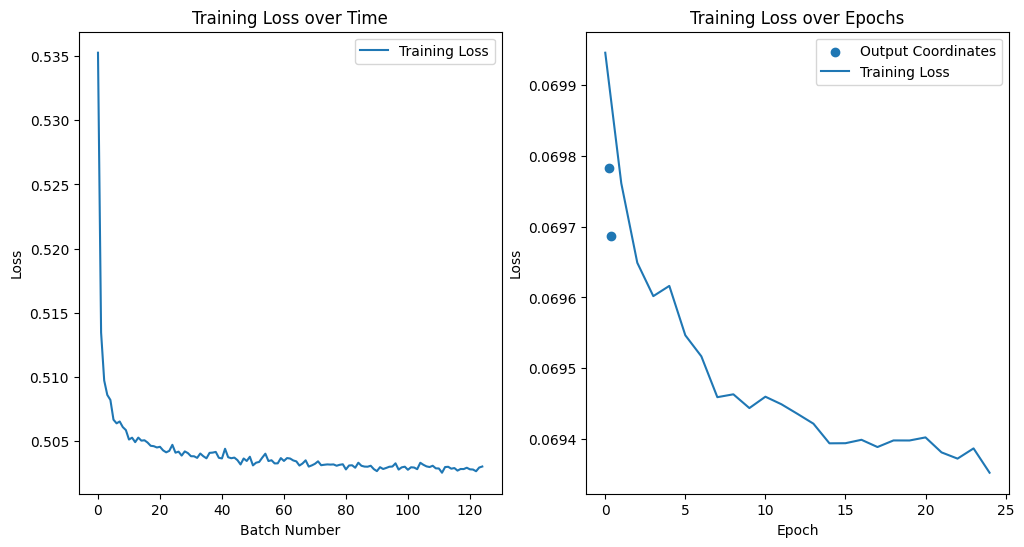

In [5]:


# class PerceptualLoss(nn.Module):
#     def __init__(self, feature_layers=[0, 5, 10, 19, 28]):
#         super(PerceptualLoss, self).__init__()
#         vgg = models.vgg19(pretrained=True).features
#         self.vgg_layers = nn.ModuleList([vgg[i] for i in feature_layers]).eval()
#         for param in self.vgg_layers.parameters():
#             param.requires_grad = False

#     def forward(self, output, target):
#         loss = 0
#         for layer in self.vgg_layers:
#             output = layer(output)
#             target = layer(target)
#             loss += nn.functional.mse_loss(output, target)
#         return loss

# criterion = PerceptualLoss()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.ssim_loss = pytorch_msssim.SSIM(win_size=11, size_average=True)

    def forward(self, output, target):
        mse = self.mse_loss(output, target)
        ssim = self.ssim_loss(output, target)
        return self.alpha * mse + (1 - self.alpha) * ssim

criterion = CombinedLoss()

# criterion = pytorch_msssim.SSIM(win_size=11, size_average=True)
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from tqdm.auto import tqdm
from sklearn.metrics import r2_score

# To store the loss values
loss_values = []
noise_factor = 0.1


# Plot setup
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
losses = []
line_loss, = ax1.plot(losses, label='Training Loss')
ax1.legend()
ax1.set_xlabel('Batch Number')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Time')

coords_x, coords_y = [], []
scatter = ax2.scatter(coords_x, coords_y, label='Output Coordinates')
ax2.legend()
ax2.set_xlabel('Coord X')
ax2.set_ylabel('Coord Y')
ax2.set_title('Output Coordinates Projection')

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    tmp = []
    for i, inputs in enumerate(dataloader, 0):
        inputs = inputs.to(device)

        # Add noise to the inputs
        noisy_inputs = inputs + noise_factor * torch.randn_like(inputs)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs, coords = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        # Print statistics and update plot
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 batches
            avg_loss = running_loss / 10
            # print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}], Loss: {avg_loss:.4f}')
            losses.append(avg_loss)
            running_loss = 0.0

            # Update loss plot
            line_loss.set_ydata(losses)
            line_loss.set_xdata(range(len(losses)))


            # Update scatter plot with new coordinates
            coords_np = coords.detach().cpu().numpy()
            coords_x.extend(coords_np[:, 0])
            coords_y.extend(coords_np[:, 1])
            scatter.set_offsets(np.c_[coords_x, coords_y])

    
    # Average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    loss_values.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

ax1.relim()
ax1.autoscale_view()

ax2.relim()
ax2.autoscale_view()

plt.draw()

print("Finished Training")

# Plotting the loss
plt.plot(range(num_epochs), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


/tmp/ipykernel_7814/1157294653.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.212604..1.1641142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028932124..1.182591].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21731974..1.1112399].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34836927..1.1474756].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2647022..1.2334282].
Clipping i

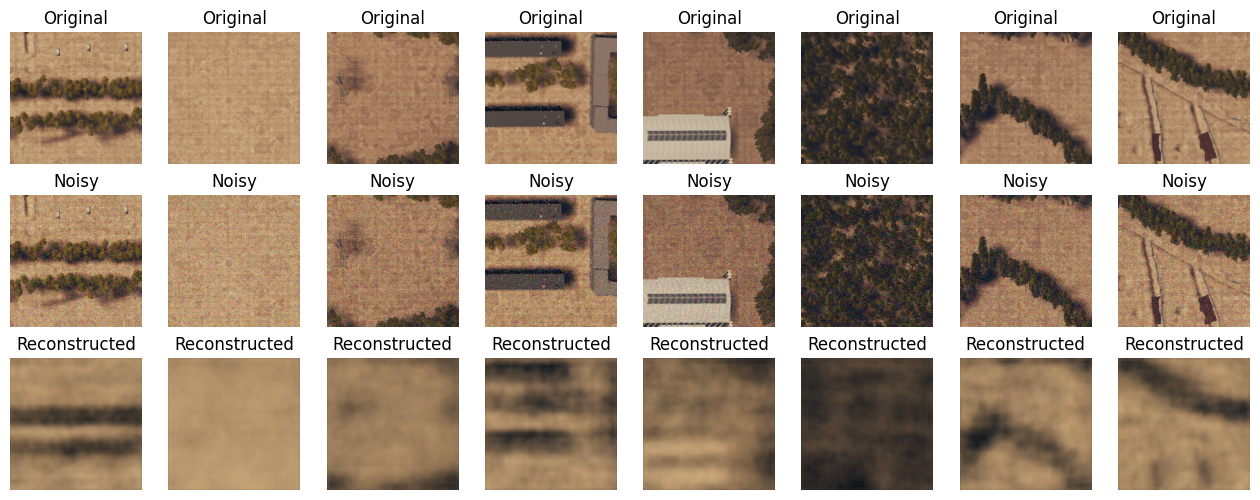

In [6]:
# Visualization
def visualize_results(model, dataloader):
    model.eval()
    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            noisy_inputs = inputs + noise_factor * torch.randn_like(inputs)
            outputs, _ = model(noisy_inputs)
            inputs = inputs.cpu().numpy()
            noisy_inputs = noisy_inputs.cpu().numpy()
            outputs = outputs.cpu().numpy()
            break

    # Plotting
    num_images = min(batch_size, 8)
    fig, axs = plt.subplots(3, num_images, figsize=(num_images * 2, 6))

    for i in range(num_images):
        axs[0, i].imshow(np.transpose(inputs[i], (1, 2, 0)))
        axs[0, i].set_title("Original")
        axs[0, i].axis('off')
        axs[1, i].imshow(np.transpose(noisy_inputs[i], (1, 2, 0)))
        axs[1, i].set_title("Noisy")
        axs[1, i].axis('off')
        axs[2, i].imshow(np.transpose(outputs[i], (1, 2, 0)))
        axs[2, i].set_title("Reconstructed")
        axs[2, i].axis('off')

    plt.show()

visualize_results(model, dataloader)


In [9]:

# Сохранение модели
model_path = 'autoencoder_model_test.h5'


torch.save(model.state_dict(), model_path)

In [10]:
# Load модели
model = Autoencoder()
model.load_state_dict(torch.load(model_path))
model.eval()

Autoencoder(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=131072, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (drop): Dropout(p=0.25, inplace=False)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=131072, bias=True)
    (deconv1): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [14]:
import gc
del model
del criterion
del optimizer
del dataloader
torch.cuda.empty_cache()
gc.collect()

131770